# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from argparse import Namespace
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    !pip install -q /kaggle/input/torchsummary/torchsummary-1.5.1-py3-none-any.whl
    
from torchsummary import summary

# load data

In [2]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
else:
    BASE_DIR =  'data'

In [3]:
configs = Namespace(
    base_dir= Path(BASE_DIR),
    batch_size= 16,
    num_worers= 2,
    shuffle= True,
    epochs= 10,
    lr=1e-3,
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

In [4]:
def get_paths(data_type):

    ids_list = os.listdir(os.path.join(configs.base_dir, data_type))

    df = pd.DataFrame(ids_list, columns=['record_id'])

    df['path'] = os.path.join(configs.base_dir, data_type ) +"/"+ df['record_id'].astype(str)

    return df

train_df = get_paths('train')
val_df = get_paths('validation')

In [5]:
train_df.head()

,record_id,path
0,1284412112608546821,/kaggle/input/google-research-identify-contrai...
1,7457695218848685981,/kaggle/input/google-research-identify-contrai...
2,836236084461732921,/kaggle/input/google-research-identify-contrai...
3,7829917977180135058,/kaggle/input/google-research-identify-contrai...
4,5319255125658459358,/kaggle/input/google-research-identify-contrai...


In [5]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, train=True):
        self.df = df  # Initialize the instance variable df to store the DataFrame.
        self.trn = train  # Initialize the instance variable trn to indicate if it is a training dataset.

    def read_record(self, directory):

        record_data = {}  # Create a dictionary to store the record data.
        for x in [
            "band_11",
            "band_14",
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))  # Load data for each band and store it in the dictionary.

        if self.trn:
            record_data["mask"] = np.load(os.path.join(directory, "human_pixel_masks.npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Normalize data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def get_false_color(self, record_data):

        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)

        N_TIMES_BEFORE = 4
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        img = false_color[..., N_TIMES_BEFORE]

        if self.trn:
            mask_img = record_data["mask"]

            return img, mask_img
        
        return img

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        data = self.read_record(con_path)  # dictionary with keys: band_11, band_14, band_15 and values: numpy arrays (height, width, channels)

        if self.trn:
            img, mask_img = self.get_false_color(data)

            img = torch.tensor(img).float()
            mask_img = torch.tensor(mask_img).float()

            img = img.permute(2, 0, 1)
            mask_img = mask_img.permute(2, 0, 1)

            return img, mask_img
        
        img = self.get_false_color(data)
        
        img = torch.tensor(img).float()

        img = img.permute(2, 0, 1)
        return img
    

    def __len__(self):
        return len(self.df)


In [6]:
train_ds = ContrailsDataset(
        train_df,
        train = True
    )

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, num_workers = configs.num_worers)

val_ds = ContrailsDataset(
        val_df,
        train = True
    )

val_dl = DataLoader(val_ds, batch_size=configs.batch_size, num_workers = configs.num_worers)

In [8]:
# fetch the one batch from the test dataloader
for xb, yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    # check the device
    print(xb.device)
    break

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
cpu


In [7]:
# delete the variables to free up the memory
del train_df, val_df, train_ds, val_ds

# Architecture

In [8]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
        
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
summary(UNet(n_channels=3, n_classes=1).to(configs.device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# Training

In [9]:
class Dice(nn.Module):
    def __init__(self, use_sigmoid=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, inputs, targets, smooth=1):
        if self.use_sigmoid:
            inputs = self.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.0 *intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
dice = Dice()

In [10]:
class MyTrainer:
    def __init__(self, model, optimizer, loss_fn, lr_scheduler):
        self.validation_losses = []
        self.batch_losses = []
        self.epoch_losses = []
        self.learning_rates = []
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self._check_optim_net_aligned()

    # Ensures that the given optimizer points to the given model
    def _check_optim_net_aligned(self):
        assert self.optimizer.param_groups[0]['params'] == list(self.model.parameters())

    # Trains the model
    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 10,
            eval_every: int = 1,
            ):
  
        for e in range(epochs):
            print("New learning rate: {}".format(self.lr_scheduler.get_last_lr()))
            self.learning_rates.append(self.lr_scheduler.get_last_lr()[0])

            # Stores data about the batch
            batch_losses = []
            sub_batch_losses = []

            for i, data in enumerate(train_dataloader):
                self.model.train()
                if (i+1) % 150 == 0:
                    print(f'epotch: {e} batch: {i}/{len(train_dataloader)} loss: {torch.Tensor(sub_batch_losses).mean()}')
                    sub_batch_losses.clear()
                # Every data instance is an input + label pair
                images, mask = data
                
                if torch.cuda.is_available():
                    images = images.cuda()
                    mask = mask.cuda()

                # Zero your gradients for every batch!
                self.optimizer.zero_grad()
                # Make predictions for this batch
                outputs = self.model(images)
                # Compute the loss and its gradients
                loss = self.loss_fn(outputs, mask)
                loss.backward()
                # Adjust learning weights
                self.optimizer.step()

                # Saves data
                self.batch_losses.append(loss.item())
                batch_losses.append(loss)
                sub_batch_losses.append(loss)
            

            # Adjusts learning rate
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            # Reports on the path
            mean_epoch_loss = torch.Tensor(batch_losses).mean()
            self.epoch_losses.append(mean_epoch_loss.item())
            print('Train Epoch: {} Average Loss: {:.6f}'.format(e, mean_epoch_loss))

            # Reports on the training progress
            if (e + 1) % eval_every == 0:
                torch.save(self.model.state_dict(), "model_checkpoint_e" + str(e) + ".pt")
                with torch.no_grad():
                    self.model.eval()
                    losses = []
                    for i, data in enumerate(test_dataloader):
                        # Every data instance is an input + label pair
                        images, mask = data

                        if torch.cuda.is_available():
                            images = images.cuda()
                            mask = mask.cuda()

                        output = self.model(images)
                        loss = self.loss_fn(output, mask)
                        losses.append(loss.item())
                        
                    avg_loss = torch.Tensor(losses).mean().item()
                    self.validation_losses.append(avg_loss)
                    print("Validation loss after", (e + 1), "epochs was", round(avg_loss, 4))

In [16]:
train = True

if train:
    model = UNet(n_channels=3, n_classes=1)
    model.to(configs.device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(100))
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.70)


    trainer = MyTrainer(model, optimizer, criterion, lr_scheduler)
    trainer.fit(train_dl, val_dl, epochs=configs.epochs)
else:
    model = UNet(n_channels=3, n_classes=1)
    model.load_state_dict(torch.load(os.path.join(configs.base_dir, 'model_checkpoint_e7.pt')))
    model.eval()
    model.to(configs.device)

New learning rate: [0.01]
epotch: 0 batch: 0/1284 loss: nan
epotch: 0 batch: 150/1284 loss: 0.7720167636871338
epotch: 0 batch: 300/1284 loss: 0.6079897284507751
epotch: 0 batch: 450/1284 loss: 0.5728740692138672
epotch: 0 batch: 600/1284 loss: 0.5393344759941101
epotch: 0 batch: 750/1284 loss: 0.47119247913360596
epotch: 0 batch: 900/1284 loss: 0.4529207944869995
epotch: 0 batch: 1050/1284 loss: 0.384272962808609
epotch: 0 batch: 1200/1284 loss: 0.37568747997283936
Train Epoch: 0 Average Loss: 0.511424
Validation loss after 1 epochs was 0.2463
New learning rate: [0.006999999999999999]
epotch: 1 batch: 0/1284 loss: nan
epotch: 1 batch: 150/1284 loss: 0.31400978565216064
epotch: 1 batch: 300/1284 loss: 0.29936522245407104
epotch: 1 batch: 450/1284 loss: 0.28995785117149353
epotch: 1 batch: 600/1284 loss: 0.25944337248802185
epotch: 1 batch: 750/1284 loss: 0.2561006546020508
epotch: 1 batch: 900/1284 loss: 0.2517531216144562
epotch: 1 batch: 1050/1284 loss: 0.2411954700946808
epotch: 1 b

# Training Progress

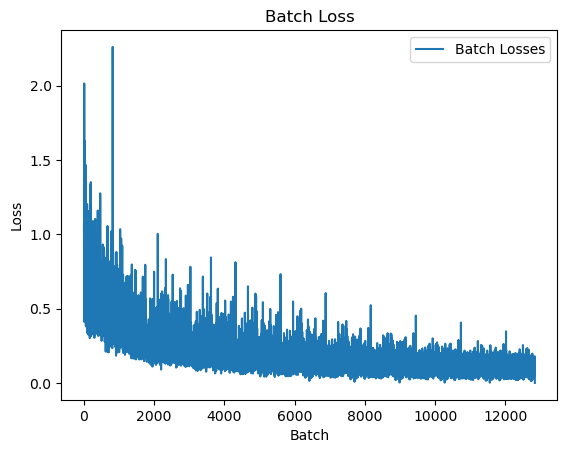

In [17]:
if train:
    df_data = pd.DataFrame({'Batch Losses': trainer.batch_losses})

    sns.lineplot(data=df_data)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Batch Loss')
    plt.show()

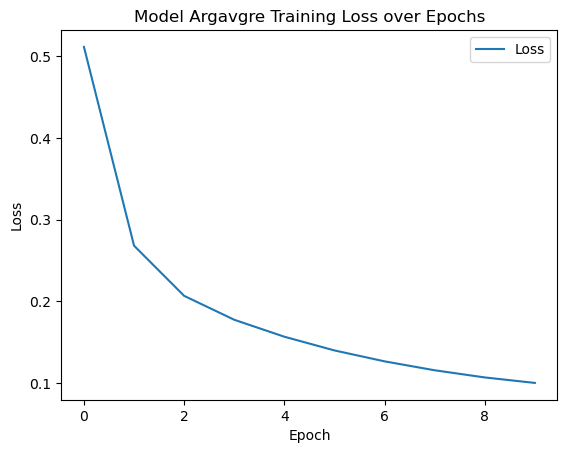

In [18]:
if train:
    df_data = pd.DataFrame({'Loss': trainer.epoch_losses})

    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Argavgre Training Loss over Epochs')
    plt.show()

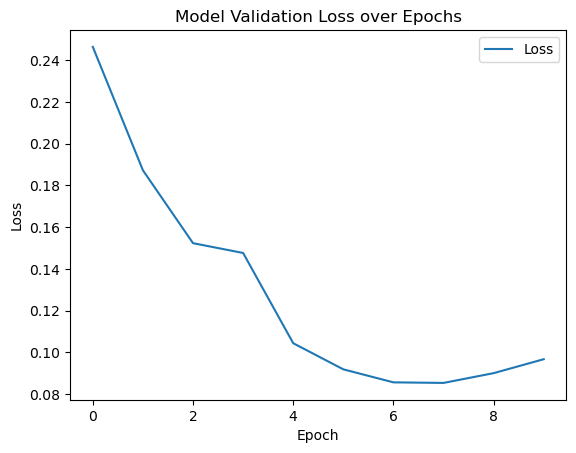

In [19]:
if train:
    df_data = pd.DataFrame({'Loss': trainer.validation_losses})

    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Validation Loss over Epochs')
    plt.show()

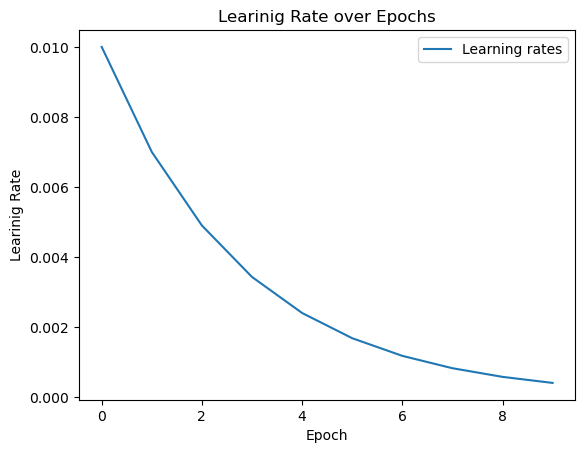

In [20]:
if train:
    df_data = pd.DataFrame({'Learning rates': trainer.learning_rates})

    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Learinig Rate')
    plt.title('Learinig Rate over Epochs')
    plt.show()

# Optimum Threshold

In [21]:
class DiceThresholdTester:
    
    def __init__(self, model: nn.Module, data_loader: torch.utils.data.DataLoader):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []
        
    def precalculate_prediction(self) -> None:
        sigmoid = nn.Sigmoid()
        
        for images, mask_true in self.data_loader:
            if torch.cuda.is_available():
                images = images.cuda()

            mask_pred = sigmoid(model.forward(images))

            self.cumulative_mask_pred.append(mask_pred.cpu().detach().numpy())
            self.cumulative_mask_true.append(mask_true.cpu().detach().numpy())
            
        self.cumulative_mask_pred = np.concatenate(self.cumulative_mask_pred, axis=0)
        self.cumulative_mask_true = np.concatenate(self.cumulative_mask_true, axis=0)

        self.cumulative_mask_pred = torch.flatten(torch.from_numpy(self.cumulative_mask_pred))
        self.cumulative_mask_true = torch.flatten(torch.from_numpy(self.cumulative_mask_true))
    
    def test_threshold(self, threshold: float) -> float:
        _dice = Dice(use_sigmoid=False)
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))
        return _dice(self.cumulative_mask_true, after_threshold).item()

In [22]:
if train:
    dice_threshold_tester = DiceThresholdTester(model, val_dl)
    dice_threshold_tester.precalculate_prediction()

In [23]:
if train:
    thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

    optim_threshold = 0.98
    best_dice_score = -1

    thresholds = []
    dice_scores = []

    for t in thresholds_to_test:
        dice_score = dice_threshold_tester.test_threshold(t)
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            optim_threshold = t

        thresholds.append(t)
        dice_scores.append(dice_score)

    print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
    df_threshold_data = pd.DataFrame({'Threshold': thresholds, 'Dice Score': dice_scores})
else:
    optim_threshold = 0.98

Best Threshold: 0.97 with dice: 0.5506385718112454


In [24]:
if train:
    df_threshold_data.tail(), df_threshold_data.shape

(     Threshold  Dice Score
 96        0.96    0.538836
 97        0.97    0.550639
 98        0.98    0.547520
 99        0.99    0.491896
 100       1.00    0.000005,
 (101, 2))

In [25]:
# plt.figure(figsize=(10,10))
# sns.lineplot(data=df_threshold_data, x='Threshold', y='Dice Score')
# plt.axhline(y=best_dice_score, color='green')
# plt.axvline(x=optim_threshold, color='green')
# plt.text(-0.02, best_dice_score * 0.96, f'{best_dice_score:.3f}', va='center', ha='left', color='green')
# plt.text(optim_threshold - 0.01, 0.02, f'{optim_threshold}', va='center', ha='right', color='green')
# plt.ylim(bottom=0)
# plt.title('Threshold vs Dice Score')
# plt.show()

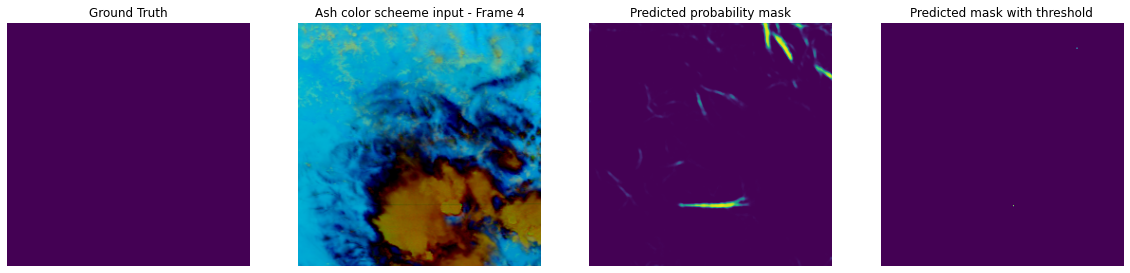

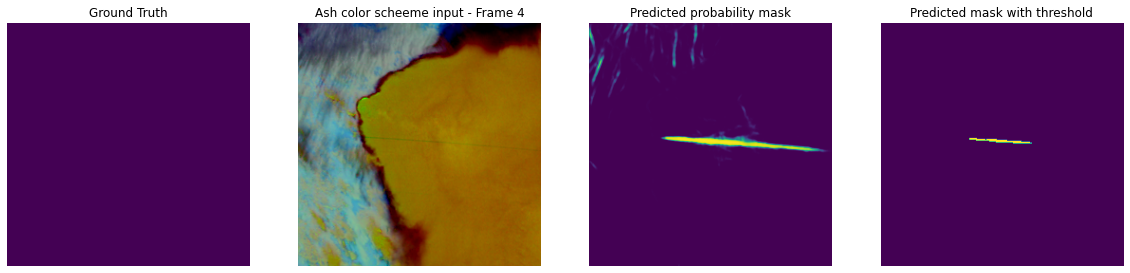

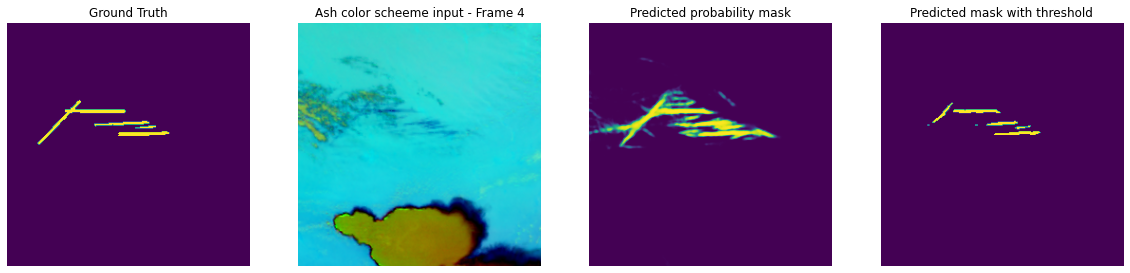

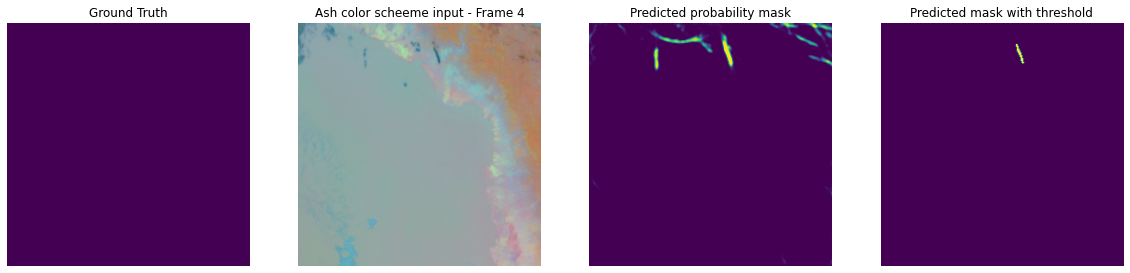

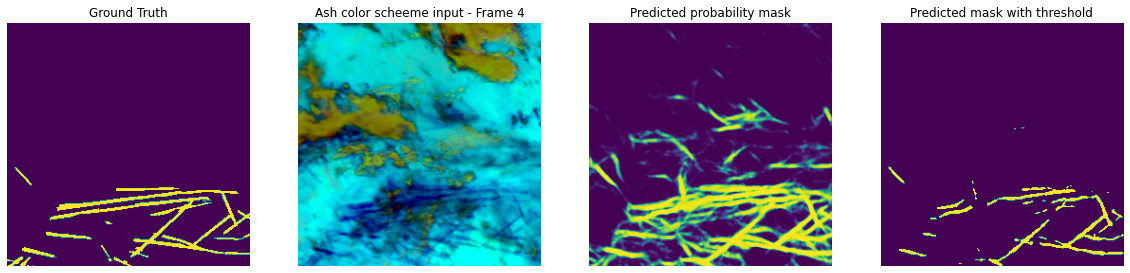

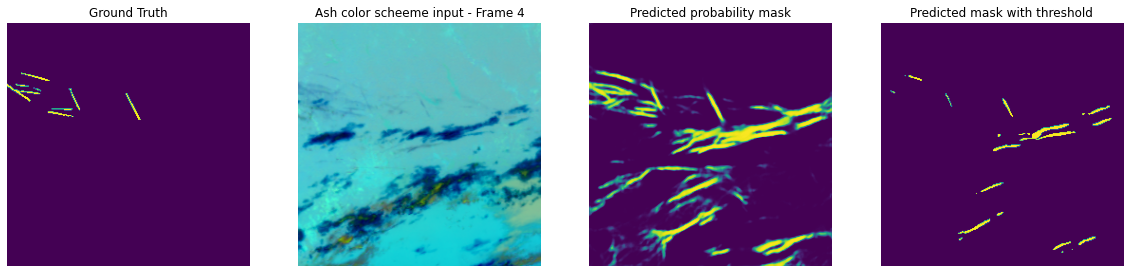

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

batches_to_show = 1
model.eval()

for i, data in enumerate(train_dl):
    images, mask = data
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())

    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    images = images.cpu()
        
    for img_num in range(0, images.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
        axes = axes.flatten()
        
        # Show groud trought 
        axes[0].imshow(mask[img_num, 0, :, :])
        axes[0].axis('off')
        axes[0].set_title('Ground Truth')
        
        # Show ash color scheme input image
        # axes[1].imshow( np.concatenate(
        #     (
        #     np.expand_dims(images[img_num, 0, :, :], axis=2),
        #     np.expand_dims(images[img_num, 1, :, :], axis=2),
        #     np.expand_dims(images[img_num, 2, :, :], axis=2)
        # ), axis=2))
        axes[1].imshow(images[img_num, :, :, :].permute(1, 2, 0))
        axes[1].axis('off')
        axes[1].set_title('Ash color scheeme input - Frame 4')

        # Show predicted mask
        axes[2].imshow(predicated_mask[img_num, 0, :, :], vmin=0, vmax=1)
        axes[2].axis('off')
        axes[2].set_title('Predicted probability mask')

        # Show predicted mask after threshold
        axes[3].imshow(predicated_mask_with_threshold[img_num, :, :])
        axes[3].axis('off')
        axes[3].set_title('Predicted mask with threshold')
        plt.show()
    
    if i + 1 >= batches_to_show:
        break

# Submission

In [16]:
test_df = get_paths('test')

# cast record_id to int
test_df["record_id"] = test_df.record_id.astype(int)

test_ds = ContrailsDataset(
        test_df,
        train = False
    )

test_batch_size = 1

test_dl = DataLoader(test_ds, batch_size=test_batch_size, num_workers = configs.num_worers)

del test_ds

In [17]:
#source https://www.kaggle.com/code/inversion/contrails-rle-submission?scriptVersionId=128527711&cellId=4

def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


In [18]:
submission = pd.read_csv(os.path.join(configs.base_dir, "sample_submission.csv"), index_col='record_id')

In [19]:
for i, images in enumerate(test_dl):
    
    
    image_id = torch.tensor(test_df.iloc[i]['record_id'])
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())
    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    current_mask = predicated_mask_with_threshold[:, :, :]
    current_image_id = image_id.item()
    submission.loc[int(current_image_id), 'encoded_pixels'] = list_to_string(rle_encode(current_mask))

In [20]:
submission.head()

,encoded_pixels
record_id,
1000834164244036115,-
1002653297254493116,-


In [21]:
submission.to_csv('submission.csv')